# RNN Surrogate Model for Double Pendulum


## 1. Import Data and Configuration

Import Configuration.

In [1]:
import yaml

with open("Configuration/DoublePendulum.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

config

{'DoF': 2,
 'PARAMETER': {'m1': 1.2, 'm2': 1.4, 'l1': 1.7, 'l2': 2.1, 'g': 9.8},
 'DATASET': {'NUM_SAMPLES': 80,
  'TIME_STEPS': 2000,
  'SAMPLING_TIME': 0.001,
  'SOLVER_SLICE': 100,
  'RELTOL': 1.01e-08,
  'ABSTOL': 1.01e-08},
 'DATA_LOADER': {'BATCH_SIZE': 8, 'SEQ_LEN': 50, 'RATIO': [0.8, 0.1, 0.1]},
 'NETWORK': {'NUM_LAYERS': 1, 'HIDDEN_SIZE': 16}}

In [2]:
len_seq = config["DATA_LOADER"]["SEQ_LEN"]
num_DoF = config["DoF"]
num_sample = config["DATASET"]["NUM_SAMPLES"]

Import Data. Data format is $[t, q_1, q_2, \dot{q}_1, \dot{q}_2, u_1, u_2]$.

In [3]:
from scipy.io import loadmat

MatData = loadmat("Data/DoublePendulum.mat")
TimeHistoryData = MatData["Data"]
print(TimeHistoryData.shape)

(160080, 7)


Convert to sequences.

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split


def PreprocessData(DATA, SEQ_LEN, TIMESTAMP=False):
    # DATA's shape is num_sample * num_features * num_time_steps
    sequences = []
    for i in range(DATA.shape[0] - SEQ_LEN + 1):
        if TIMESTAMP:
            if not np.isnan(DATA[i : i + SEQ_LEN, :]).any():
                sequences.append(DATA[i : i + SEQ_LEN, :])
        elif not np.isnan(DATA[i : i + SEQ_LEN, :]).any():
            sequences.append(DATA[i : i + SEQ_LEN, 1:])
    return np.array(sequences)


DataSet = PreprocessData(TimeHistoryData, len_seq, TIMESTAMP=False)
DataSet.shape


(156080, 50, 6)

Create Data Set of Sequencial Data for Training, Validation and Test.

In [5]:
def CreateDataLoader(DATA, BATCH_SIZE=16, RATIO=None, SHUFFLE=True):
    if RATIO is None:
        RATIO = [0.8, 0.1, 0.1]
    DataSet = TensorDataset(DATA)
    TrainSize = int(len(DataSet) * RATIO[0])
    ValSize = int(len(DataSet) * RATIO[1])
    TestSize = len(DataSet) - TrainSize - ValSize

    train_dataset, val_dataset, test_dataset = random_split(
        DataSet, [TrainSize, ValSize, TestSize]
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
    # print(len(train_dataset))
    # print(train_dataset[0][0].shape)
    return train_loader, val_loader, test_loader


DataSet = torch.tensor(DataSet, dtype=torch.float32)
TrainLoader, ValLoader, TestLoader = CreateDataLoader(
    DataSet,
    BATCH_SIZE=config["DATA_LOADER"]["BATCH_SIZE"],
    RATIO=config["DATA_LOADER"]["RATIO"],
    SHUFFLE=True,
)

## 2. Define RNN Model


RNN Cell.

In [6]:
class RNN_Cell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(RNN_Cell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter("bias", None)

        self.W_hh = nn.Linear(hidden_size, hidden_size)
        self.W_xh = nn.Linear(input_size, hidden_size)

    def forward(self, x, h):
        h_t = self.W_hh(h) + self.W_xh(x)
        if self.bias is not None:
            h_t += self.bias
        return torch.tanh(h_t)

RNN Model.

In [7]:
class SequentialModel(nn.Module):

    def __init__(self,
                 core,
                 input_size,
                 hidden_size,
                 output_size,
                 num_layers=1):
        super(SequentialModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.cells = nn.ModuleList(
            [core(input_size, hidden_size)] +
            [core(hidden_size, hidden_size) for _ in range(num_layers - 1)])
        self.fc = nn.Linear(hidden_size, output_size)  # 输出层

    def forward(self, x, h_0=None):
        batch_size, seq_len, _ = x.size()
        if h_0 is None:
            h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        else:
            h = h_0.clone()
        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :]
            new_h = []  # 使用新列表保存每层状态
            for layer in range(self.num_layers):
                h_layer = h[layer].clone()  # 克隆当前层状态
                h_layer = self.cells[layer](x_t, h_layer)
                new_h.append(h_layer)
                x_t = h_layer  # 下一层输入
            h = torch.stack(new_h, dim=0)  # 更新整个隐藏状态
            outputs.append(self.fc(x_t))
        outputs = torch.stack(outputs, dim=1)
        return outputs, h


## 3. Train RNN Model


Training function.

In [8]:
from tqdm import tqdm
from utils.NN_utils import *


def train_model(model,
                device,
                train_loader,
                val_loader,
                num_epochs=100,
                lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        # 使用 tqdm 显示进度条
        with tqdm(train_loader,
                  desc=f"Epoch {epoch+1}/{num_epochs}",
                  unit="batch") as tepoch:
            for batch in tepoch:
                inputs = batch[0]  # [batch_size, seq_len, 6]
                # 输入为前5步的状态+控制量，输出为后5步的状态（假设单步预测）
                x = inputs[:, :-1, :]  # [batch, seq_len-1, 6]
                y = inputs[:, 1:, :4]  # 预测下一时刻的q1, q2, dq1, dq2

                optimizer.zero_grad()
                outputs, _ = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # 更新进度条的描述信息，显示当前的训练损失
                tepoch.set_postfix(train_loss=train_loss / (tepoch.n + 1))

        # 验证集
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0]
                x = inputs[:, :-1, :]
                y = inputs[:, 1:, :4]
                outputs, _ = model(x)
                val_loss += criterion(outputs, y).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses


Define model

In [9]:
input_size = 6  # [q1, q2, dq1, dq2, u1, u2]
output_size = 4  # [q1, q2, dq1, dq2]
model = SequentialModel(core=RNN_Cell,
                        input_size=input_size,
                        hidden_size=config["NETWORK"]["HIDDEN_SIZE"],
                        output_size=output_size,
                        num_layers=config["NETWORK"]["NUM_LAYERS"])

Training

In [10]:
train_losses, val_losses = train_model(model,
                                       GET_DEVICE(),
                                       TrainLoader,
                                       ValLoader,
                                       num_epochs=2,
                                       lr=0.001)

Epoch 2/2: 100%|██████████| 15608/15608 [02:11<00:00, 118.44batch/s, train_loss=0.000644]


## 4. Visualize Results

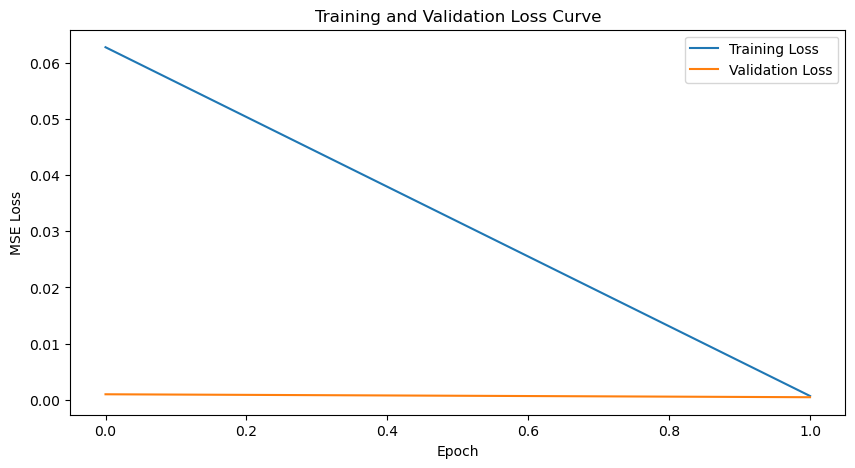

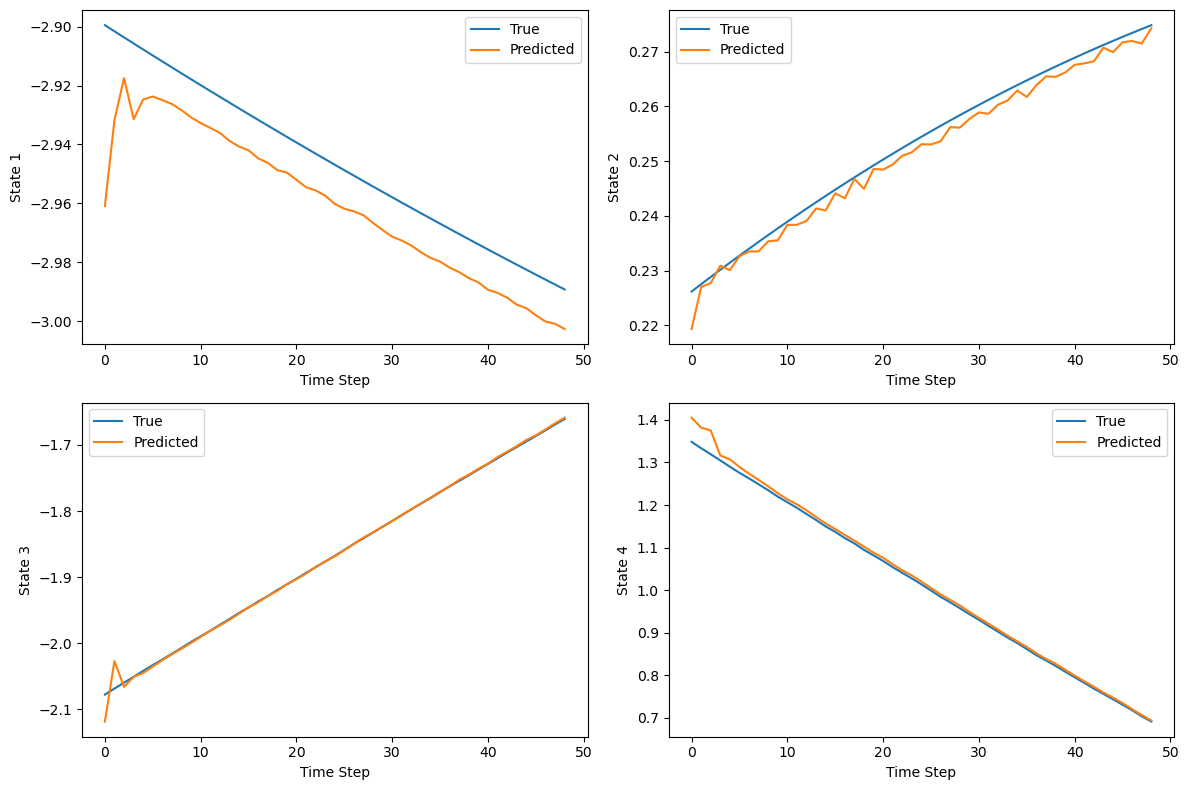

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training and Validation Loss Curve")
plt.show()


# 测试集预测示例
def plot_predictions(model, test_loader):
    model.eval()
    with torch.no_grad():
        test_batch = next(iter(test_loader))[0]
        x = test_batch[:, :-1, :]
        y_true = test_batch[:, 1:, :4]
        y_pred, _ = model(x)

    # 取第一个样本
    sample_idx = 0
    time_steps = np.arange(y_true.size(1))

    plt.figure(figsize=(12, 8))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(time_steps, y_true[sample_idx, :, i].numpy(), label="True")
        plt.plot(time_steps,
                 y_pred[sample_idx, :, i].numpy(),
                 label="Predicted")
        plt.xlabel("Time Step")
        plt.ylabel(f"State {i+1}")
        plt.legend()
    plt.tight_layout()
    plt.show()


plot_predictions(model, TestLoader)

## 5. Save Model

Save model in `Pytorch` format, under `./Model` directory.

In [12]:
torch.save(model.state_dict(), "./Model/double_pendulum_rnn.pth")